# **CS145: Project 3 | What characterizes the most popular Ethereum projects?**

## **Project Overview**

The central question I explore is: what characterizes the most popular projects on the Ethereum blockchain, past and present? I look to identify trends and correlations between certain on-chain statistics and the popularity of a project. For the intents and purposes of this project, I define popularity **in terms of unique user count.**

The sub-questions I examine to answer the central question above are listed below:
- What industry categories do the most popular/used projects fall under?
- How is average value transacted correlated to project popularity? Does high average value transacted point towards a contract having high usage?
- How is the average computational cost of transactions (measured in gas) correlated to project usage? Do the most popular projects contain more complex business logic that requires more computation?
- How might daily transaction volume be correlated with project usage? Will the most used projects have sustained usage over time or spikes in usage?
- How is current internal contract balance correlated to project usage? Does a low internal balance suggest that the contract has lots of traffic but that funds flow through it rather than being stored long term?
- Do the most popular projects frequently transfer their tokens to other contracts?

## **Analysis of Dataset**

**Name:** crypto_ethereum

**Number of Tables:** 8

**Total Size:** 2.4 TB

**Overview:** 

The crypto_ethereum dataset contains a vast array of public data stored on the Ethereum blockchain. The dataset is divided into 8 different tables, each of which characterizes a specific aspect of users and contracts on Ethereum: balances, blocks, contracts, logs, token_transfers, tokens, traces, and transactions. The tables used for my project, in particular, were the balances (8 GB), contracts (30.01 GB), token_transfers (153.85 GB), and transactions (412.33 GB) tables.

The *address* field was the common primary key that tied together data across the different tables I used, as each contract address identifies a unique project. Similarly, the contracts table played a unifying role and provided the addresses of all contracts on the Ethereum network as well some less important details about each contract, such as its creation timestamp and characterization as an ERC20 or ERC721 contract. 

The transactions table served as the heart and soul of my analysis and was a collection of transaction metadata for every transaction ever executed on Ethereum. Aggregate operations such as counting and averaging were quite useful on this table. The most important features provided by the transactions table included transaction value, gas cost, timestamp, to_address, and from_address.

The balances table was relatively simple and only consisted of the contract (or user) address and the corresponding current balance linked to that address. The token_transfers table was also important to my analysis and provided me with the to and from addresses for each token transfer, allowing me to see where certain contracts were transferring their tokens.


## **Data Exploration**

In [2]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "finalproject-293702"

In [3]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from datetime import datetime
import matplotlib.ticker as ticker

## List of Queries
In order to reduce query costs, I saved queried data to intermediate tables that could be reused for the duration of the project. These tables and the queries used to build them are listed below.


---
### **Transaction and Usage Data**

**Name:** top-100k-tx-data

**Schema:**
- address: *STRING*
- total_transactions: *INTEGER*
- unique_users: *INTEGER*
- total_value_transacted: *NUMERIC*
- avg_value_transacted: *NUMERIC*
- avg_gas_provided: *FLOAT*
- avg_gas_used_tx: *FLOAT*
- avg_gas_used_block: *FLOAT*
- earliest_tx: *TIMESTAMP*
- latex_tx: *TIMESTAMP*



**Query:**
```
SELECT
  contracts.address,
  COUNT(DISTINCT transactions.hash) as total_transactions,
  COUNT(DISTINCT transactions.from_address) as unique_users,
  SUM(transactions.value) AS total_value_transacted,
  AVG(transactions.value) AS avg_value_transacted,
  AVG(transactions.gas_price) AS avg_gas_provided,
  AVG(transactions.receipt_gas_used) AS avg_gas_used_tx,
  AVG(transactions.receipt_cumulative_gas_used) AS avg_gas_used_block,
  MIN(transactions.block_timestamp) AS earliest_tx,
  MAX(transactions.block_timestamp) AS latest_tx
FROM
  `bigquery-public-data.crypto_ethereum.contracts` AS contracts
JOIN
  `bigquery-public-data.crypto_ethereum.transactions` AS transactions
ON
  (transactions.to_address = contracts.address)
WHERE
  transactions.value > 0
  AND contracts.is_erc20 = TRUE
GROUP BY
  contracts.address
ORDER BY
  unique_users DESC
LIMIT
  100000
  ```


---
### **Daily Transaction Data**

**Name:** top-100k-daily-tx-data

**Schema:**
- address: *STRING*
- value_transacted: *NUMERIC*
- tx_count: *INTEGER*
- date: *DATE*

**Query:**
```
SELECT 
  tx_data.address as address, 
  SUM(transactions.value) as value_transacted, 
  COUNT(transactions) as tx_count, 
  DATE(transactions.block_timestamp) as date
FROM 
  `bigquery-public-data.crypto_ethereum.transactions` as transactions
  JOIN `finalproject-293702.project_3_saved.top-100k-usage-tx-data` as tx_data
  ON transactions.to_address = tx_data.address
WHERE transactions.value > 0
GROUP BY date, tx_data.address
  ```
  ---


### **Current Internal Contract Balances**

**Name:** top-100k-usage-balances

Schema:
- address: *STRING*
- eth_balance: *NUMERIC*

**Query:**
```
SELECT
  balances.address, 
  balances.eth_balance
FROM 
  `bigquery-public-data.crypto_ethereum.balances` as balances
  JOIN `finalproject-293702.project_3_saved.top-100k-usage-tx-data` as top_100k_tx_data
  ON balances.address = top_100k_tx_data.address
  ```
  ---

### **Token Transfers From Contract**

**Name:** top-100k-transfers-from

**Schema:**
- contract_address: *STRING*
- value: *NUMERIC*
- to_address: *STRING*
- timestamp: *TIMESTAMP*

**Query:**
```
SELECT 
  top_100k_tx_data.address as contract_address, 
  transfers.value as value, 
  transfers.to_address as to_address,
  transfers.block_timestamp as timestamp
FROM 
  `bigquery-public-data.crypto_ethereum.token_transfers` as transfers
  JOIN `finalproject-293702.project_3_saved.top-100k-usage-tx-data` as top_100k_tx_data
  ON transfers.from_address = top_100k_tx_data.address
  ```
  ---

### **Number of Contract vs. User Transfers**

**Name:** contract-vs-user-transfers

**Schema:**
- contract_address: *STRING*
- num_contract_transfers: *INTEGER*
- num_user_transfers: *INTEGER*

**Query:**
```
SELECT 
  transfers.contract_address,
  COUNTIF(transfers.to_address IN (SELECT address FROM `bigquery-public-data.crypto_ethereum.contracts`)) as num_contract_transfers,   
  COUNT(*) - COUNTIF(transfers.to_address IN (SELECT address FROM `bigquery-public-data.crypto_ethereum.contracts`)) as num_user_transfers
FROM
  `finalproject-293702.project_3_saved.top-100k-transfers-from` as transfers
GROUP BY transfers.contract_address
  ```
  ---




### **Number of Days With at Least One Transaction**

**Name:** top-100k-num-tx-days

**Schema:**
- address: *STRING*
- num_tx_days: *INTEGER*

**Query:**
```
SELECT 
  address,
  COUNT(*) as num_tx_days
FROM
  `finalproject-293702.project_3_saved.top-100k-daily-tx-data`
GROUP BY address
  ```
  ---

## Analysis

### **What categories do the most popular projects fall under?**

**Summary:**

After manually looking up the projects corresponding to the top 40 most popular contract addresses, the most popular categories appear to be utility projects for the Ethereum platform, currency exchanges and trading platforms, gaming and gambling projects, finance projects, and advertising platforms. Some of the specific project names in these categories are listed below.


Utility (7): WETH (wrapped ether), PCHAIN, EtherPlus, Bitcoin Eos, BlockCAT, NeoCash, Fantom

Exchange/Trade (7): DigitexFutures, Loopring, Cobinhood, SPECTRE, IG, OpenANX, EtherDelta

Gaming/Gambling (5): Dao.Casino, Stella Del Futuro, Decent.Bet, iDice, SmartBillions

Finance (4): TheDAO, Real Estate Asset Ledger, ETHLend, Sigma

Advertising (4): BAT, Lancer Network, AdEx, CDX

Text(0, 0.5, 'Number of Projects')

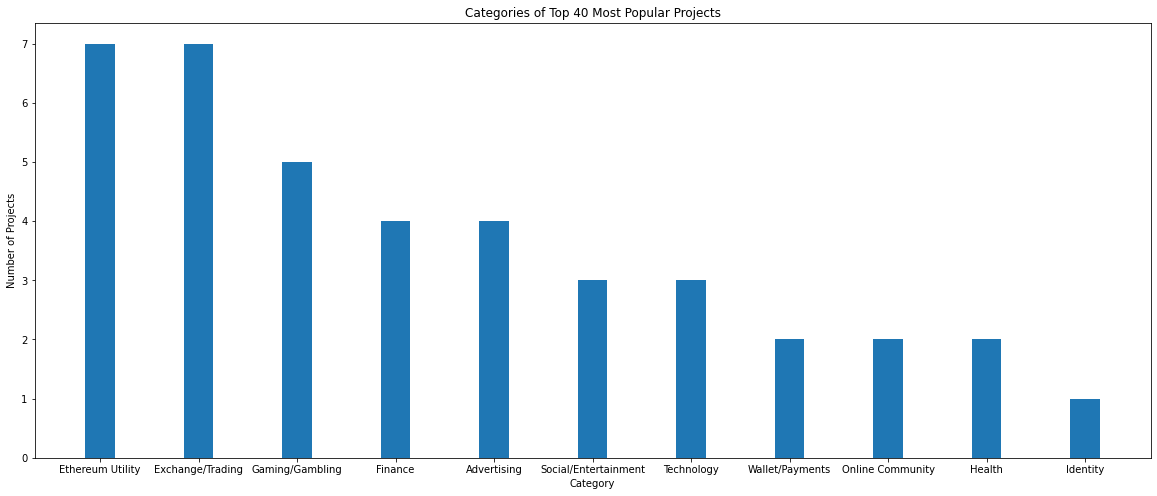

In [5]:
plt.figure(figsize=(20,8))
plt.bar(['Ethereum Utility', 
         'Exchange/Trading', 
         'Gaming/Gambling', 
         'Finance', 
         'Advertising', 
         'Social/Entertainment', 
         'Technology', 
         'Wallet/Payments',
         'Online Community',
         'Health',
         'Identity'], 
        [7,7,5,4,4,3,3,2,2,2,1], 
        width=0.3)
plt.title("Categories of Top 40 Most Popular Projects")
plt.xlabel("Category")
plt.ylabel("Number of Projects")



---



### **How is average value transacted correlated to project popularity?**

**Summary:**

As shown by the data and visualization, higher average value transacted seems to suggest greater project popularity. Initially, I thought projects with a high volume of low-value transactions might be the more popular ones and that the distribution below would be shifted further to the left. The data seems to indicate that the most popular projects tend to have an average transaction value between 1/1000 and 10 ether. This is, however, difficult to interpret in dollars due to the fact that the price of ether has changed so much over time. Still, the fact that the distribution for more popular projects was clearly centered around a specific range made average transaction value a good feature to include for the machine learning model.

In [ ]:
%%bigquery --project $project_id top_100k_tx_data

SELECT *
FROM `finalproject-293702.project_3_saved.top-100k-usage-tx-data`

In [ ]:
top_100k_tx_df = pd.DataFrame(top_100k_tx_data)
WEI_TO_ETH = 10**18

Text(0.5, 0, 'Average Value Transacted')

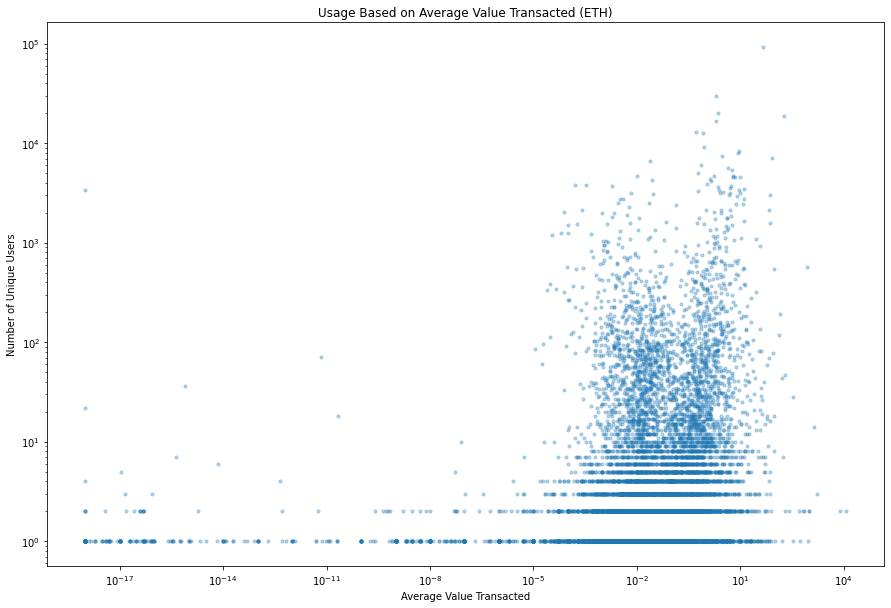

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(top_100k_tx_df["avg_value_transacted"].div(WEI_TO_ETH), top_100k_tx_df["unique_users"], s=10, alpha=0.3)
plt.xscale("log")
plt.yscale("log")
plt.title("Usage Based on Average Value Transacted (ETH)")
plt.ylabel("Number of Unique Users")
plt.xlabel("Average Value Transacted")




---



### **How is the average computational cost of transactions (measured in gas) correlated to project popularity?**

**Summary:**

The data and visualization below suggest that there is likely a "sweet spot" for computational costs required to interact with the most popular projects. It looks like this range is between 0 and 1,000,000 wei (one wei = 10^-18 ether). The likely explanation for this is that many of the most popular projects have a reasonable degree of complexity in their contract business logic but at the same time, the most popular projects likely have better engineers who can optimize this business logic to reduce the computational costs incurred on users. Since much of the difficulty of writing Solidity smart contracts comes from creating logic and operations that are as efficient as possible, it isn't entirely unexpected that there is a balance between the complexity of business logic and computational efficiency, as shown in the distribution below.

In [ ]:
%%bigquery --project $project_id top_100k_tx_data

SELECT *
FROM `finalproject-293702.project_3_saved.top-100k-usage-tx-data`

In [ ]:
top_100k_tx_df = pd.DataFrame(top_100k_tx_data)
WEI_TO_ETH = 1000000000000000000

Text(0.5, 0, 'Average Gas Cost (wei)')

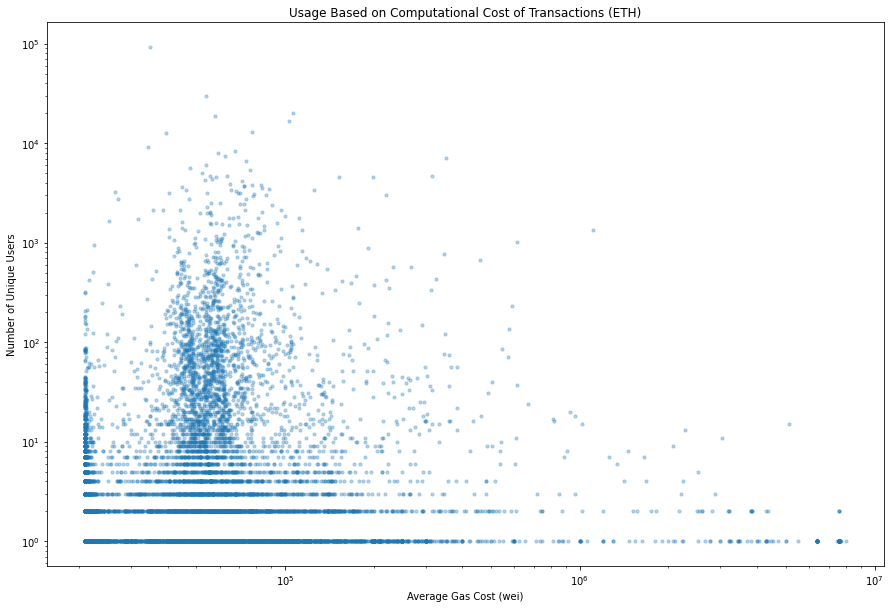

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(top_100k_tx_df["avg_gas_used_tx"], top_100k_tx_df["unique_users"], s=10, alpha=0.3)
plt.xscale("log")
plt.yscale("log")
plt.title("Usage Based on Computational Cost of Transactions (ETH)")
plt.ylabel("Number of Unique Users")
plt.xlabel("Average Gas Cost (wei)")



---



### **What does daily transaction volume for some of the most popular projects look over time?**

**Summary:**

Extracting insights from this data was particularly difficult because each project has its own graph. I didn't have any particular preconceptions about what I might find from visualizing this data but found a few interesting patterns. One noticeable observation was that for the 10 projects graphed below, WETH (wrapped ether) is the only project that was started during/after 2018. As expected, most of the projects which gained the highest user counts started in 2017, when Ethereum had been gaining the most excitement and attention. Other than this, it looks like several of the projects which might have previously had the highest user counts ended up dropping off in activity after 2017, as there are many days within some of the project graphs with no data points, indicating zero transactions occurring on those days. In order to capture any patterns related to timing and activity over time, I decided to include the earliest transaction date (start date), latest transaction date, and the number of days with at least one transaction in the ML model.

In [6]:
%%bigquery --project $project_id top_100k_daily_tx_data

SELECT *
FROM `finalproject-293702.project_3_saved.top-100k-daily-tx-data`

In [7]:
top_100k_daily_tx_df = pd.DataFrame(top_100k_daily_tx_data)
WEI_TO_ETH = 1000000000000000000

In [8]:
weth_daily = top_100k_daily_tx_df.loc[top_100k_daily_tx_df['address'] == '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2']
indahash_daily = top_100k_daily_tx_df.loc[top_100k_daily_tx_df['address'] == '0x5136c98a80811c3f46bdda8b5c4555cfd9f812f0']
thedao_daily = top_100k_daily_tx_df.loc[top_100k_daily_tx_df['address'] == '0xbb9bc244d798123fde783fcc1c72d3bb8c189413']
envion_daily = top_100k_daily_tx_df.loc[top_100k_daily_tx_df['address'] == '0xd780ae2bf04cd96e577d3d014762f831d97129d0']
pchain_daily = top_100k_daily_tx_df.loc[top_100k_daily_tx_df['address'] == '0xb9bb08ab7e9fa0a1356bd4a39ec0ca267e03b0b3']
digitex_daily = top_100k_daily_tx_df.loc[top_100k_daily_tx_df['address'] == '0x1c83501478f1320977047008496dacbd60bb15ef']
pillar_daily = top_100k_daily_tx_df.loc[top_100k_daily_tx_df['address'] == '0xe3818504c1b32bf1557b16c238b2e01fd3149c17']
cobinhood_daily = top_100k_daily_tx_df.loc[top_100k_daily_tx_df['address'] == '0xb2f7eb1f2c37645be61d73953035360e768d81e6']
bat_daily = top_100k_daily_tx_df.loc[top_100k_daily_tx_df['address'] == '0x0d8775f648430679a709e98d2b0cb6250d2887ef']
neodium_daily = top_100k_daily_tx_df.loc[top_100k_daily_tx_df['address'] == '0xf03bfb08a807716e3340e175b98b388d2dc56de0']

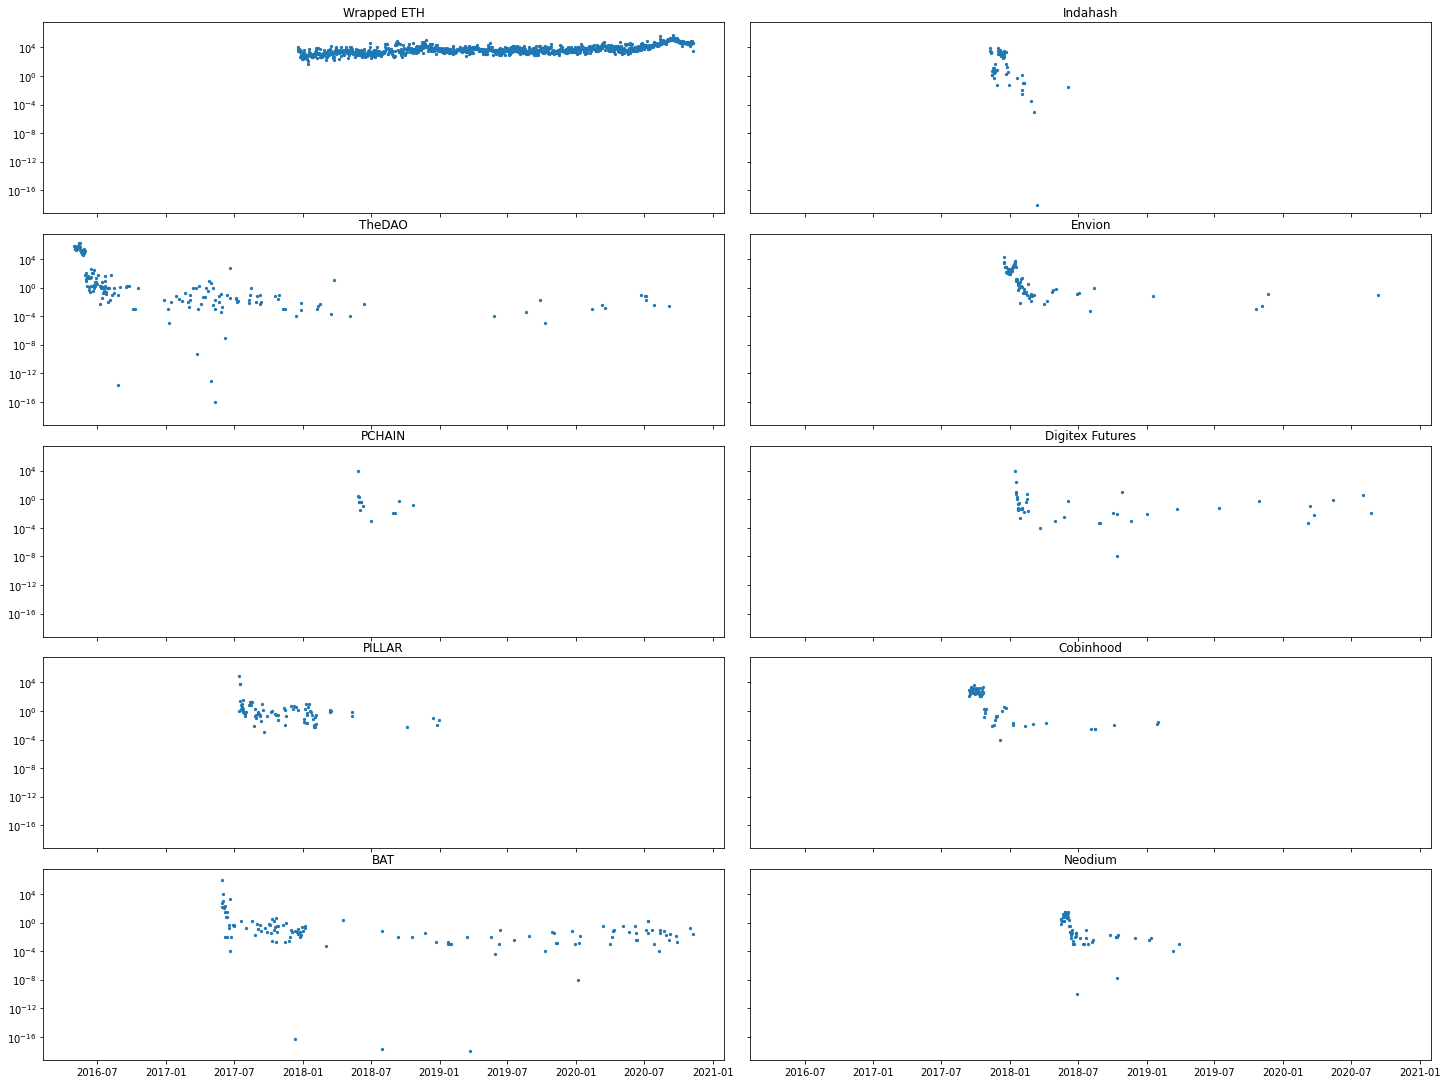

In [9]:
fig, ((ax1, ax2),(ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(20,15), sharey=True, sharex=True)
fig.tight_layout()

ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')
ax5.set_yscale('log')
ax6.set_yscale('log')
ax7.set_yscale('log')
ax8.set_yscale('log')
ax9.set_yscale('log')
ax10.set_yscale('log')

ax1.set_title("Wrapped ETH")
ax2.set_title("Indahash")
ax3.set_title("TheDAO")
ax4.set_title("Envion")
ax5.set_title("PCHAIN")
ax6.set_title("Digitex Futures")
ax7.set_title("PILLAR")
ax8.set_title("Cobinhood")
ax9.set_title("BAT")
ax10.set_title("Neodium")

ax1.scatter(weth_daily["date"], weth_daily["value_transacted"].div(WEI_TO_ETH), s=5)
ax2.scatter(indahash_daily["date"], indahash_daily["value_transacted"].div(WEI_TO_ETH), s=5)
ax3.scatter(thedao_daily["date"], thedao_daily["value_transacted"].div(WEI_TO_ETH), s=5)
ax4.scatter(envion_daily["date"], envion_daily["value_transacted"].div(WEI_TO_ETH), s=5)
ax5.scatter(pchain_daily["date"], pchain_daily["value_transacted"].div(WEI_TO_ETH), s=5)
ax6.scatter(digitex_daily["date"], digitex_daily["value_transacted"].div(WEI_TO_ETH), s=5)
ax7.scatter(pillar_daily["date"], pillar_daily["value_transacted"].div(WEI_TO_ETH), s=5)
ax8.scatter(cobinhood_daily["date"], cobinhood_daily["value_transacted"].div(WEI_TO_ETH), s=5)
ax9.scatter(bat_daily["date"], bat_daily["value_transacted"].div(WEI_TO_ETH), s=5)
ax10.scatter(neodium_daily["date"], neodium_daily["value_transacted"].div(WEI_TO_ETH), s=5)




---



### **How is current internal contract balance correlated to project popularity?**

**Summary:**

From the visualization below, it looks like projects with higher internal contract balances tend to have a higher number of unique users. Still, there are some outliers on the left. Before examining this question, I wasn't sure whether or not I would find the opposite conclusion, as having a high internal balance doesn't necessarily imply high usage. A contract that sees high volume but is focused on facilitating transactions between users might still have a lower internal balance since it simply plays a middleman role. While the conclusion about higher internal contract balances being correlated to greater popularity isn't entirely clear, I ended up using this metric in my model just in case.

In [ ]:
%%bigquery --project $project_id top_100k_balances

SELECT tx_data.address, tx_data.unique_users, balances.eth_balance
FROM 
  `finalproject-293702.project_3_saved.top-100k-usage-balances` as balances
  JOIN `finalproject-293702.project_3_saved.top-100k-usage-tx-data` as tx_data
  ON balances.address = tx_data.address

Text(0, 0.5, 'Number of Unique Users')

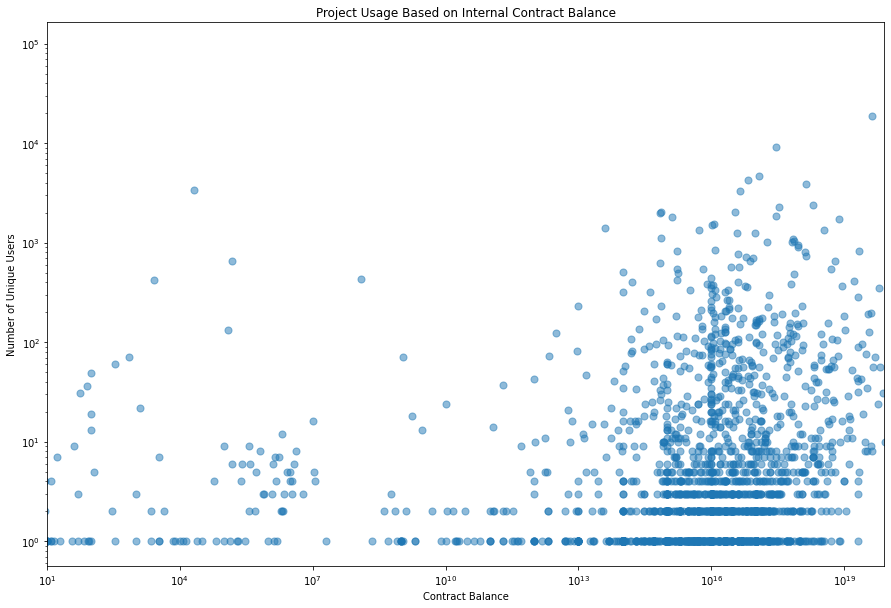

In [ ]:
top_100k_balances = pd.DataFrame(top_100k_balances)
plt.figure(figsize=(15,10))
plt.scatter(top_100k_balances["eth_balance"], top_100k_balances["unique_users"], s=50, alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.xlim([10, 10**19.9])

plt.title("Project Usage Based on Internal Contract Balance")
plt.xlabel("Contract Balance")
plt.ylabel("Number of Unique Users")



---



### **Do the most popular projects frequently transfer their tokens to other *contracts*?**

**Summary:**

Of all the questions I explored, the results of this exploration was the most surprising. I initially believed that contracts which commonly sent their tokens to other contracts might tend to be more popular and that cross-contract interaction could be a sign of a project having a stronger and broader presence in the Ethereum ecosystem. The results below, however, show that the majority of all contracts actually have very few cross-contract token transfers, with the most popular projects having close to zero cross-contract transfers. The only explanation I can think of for this anomaly is that token transfers themselves to other contracts simply aren't that common but that general transfers of *ether* are. I briefly tried answering this exact question by querying general transactions between contracts but was finding no results returned, causing me to believe there was missing data in the transactions table that perhaps excluded general cross-contract transactions.

In [ ]:
%%bigquery --project $project_id contract_vs_user_transfers

SELECT 
  tx_data.address,
  tx_data.unique_users,
  transfers.num_contract_transfers,
  transfers.num_user_transfers
FROM 
  `finalproject-293702.project_3_saved.contract-vs-user-transfers` as transfers
  JOIN `finalproject-293702.project_3_saved.top-100k-usage-tx-data` as tx_data
  ON transfers.contract_address = tx_data.address

Text(0, 0.5, 'Number of Unique Users')

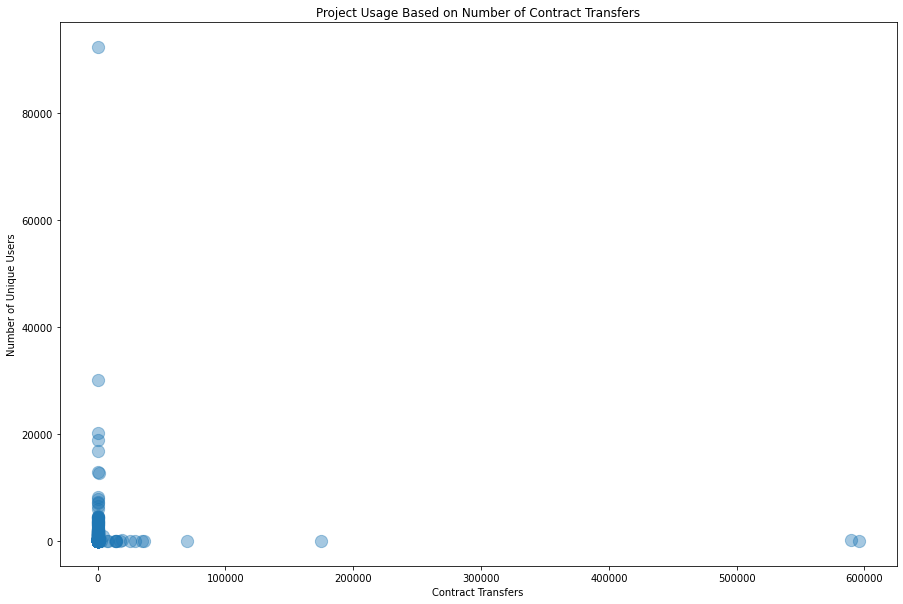

In [ ]:
contract_vs_user_transfers = pd.DataFrame(contract_vs_user_transfers)
plt.figure(figsize=(15,10))
plt.scatter(contract_vs_user_transfers["num_contract_transfers"], contract_vs_user_transfers["unique_users"], s=150, alpha=0.4)

plt.title("Project Usage Based on Number of Contract Transfers")
plt.xlabel("Contract Transfers")
plt.ylabel("Number of Unique Users")



---



### **Data Analysis Summary**

Reviewing the insights learned from the data analysis above, I decided that the most useful features with noticeable correlations were average value transacted (total value transacted/number of transactions), average computational cost per transaction, the earliest transaction date (essentially the project's start date), the latest transaction date, the number of days the project had with at least one transaction, and the contract's current internal balance. Average value transacted plotted against user count appeared to have a distribution centered around the range of 1/1000 to 10 ether. Average computational cost per transaction against user count had a distribution centered around the range of 0 to 10^5 wei. As expected even before this project, many of the projects which achieved the highest user counts started in 2017 and seemed to have dropped off in activity since then, thus including earliest and latest transaction dates as well as the total number of days with at least one transaction seemed appropriate to capture trends regarding timing and sustained activity. Lastly, the distribution of internal contract balance against user count seemed centered around the range of 10^13 to 10^19 ether, making this a potentially useful feature as well.

## **ML Training/Predictions**

### Logistic Regression Model

***Data Split***: train / evaluation / test ---> 80 / 10 / 10

**Objective:** 

Given a contract's average value transacted, average gas used per transaction (average gas cost), earliest transaction date, latest transaction date, number of days with at least one transaction, and current internal balance, predict whether or not the contract is among the top 10% most popular projects (by number of unique users).

**Summary**:

I originally tried creating a linear regression model that would predict the number of unique users a project had given the training features. Unfortunately, the distribution for the number of unique users per contract had quite a long tail (i.e. many projects had user counts < 5), making this task more difficult than expected. The logistic regression model, however, performed quite well. I layered on different features one at a time to see which ones would be the most important and the most significant features turned out to be the earliest transaction date, the latest transaction date, and the number of days with at least one transaction. Initially, with all features except for these three, the model was only achieving an accuracy of around 60% and had an AUC under 0.45. After adding these three features, the model's accuracy was bumped all the way up to 94%, with AUC also being increased to 0.94. Thus, the most important features by far turned out to be those regarding the timing of the project and duration of usage. Lastly, it is worth noting that adding class weights to the model helped improve performance too, since the model's dataset is quite imbalanced with only 10% positive labels. On a similar note, the low recall of 0.54 and F1 score of 0.64 may be a result of the fact that there are so few positive examples, as just missing a few positives would lead to a lower recall than one might expect. Given the higher precision and lower recall, it looks like when the model outputs positive predictions it is usually right, but the model is still outputting a substantial amount of false negatives, perhaps still due to the fact that the data is simply unbalanced.

In [ ]:
model_dataset_name = 'ethereum_project_popularity'
dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

Dataset(DatasetReference('finalproject-293702', 'ethereum_project_popularity'))


### Model Dataset Query
```
SELECT 
  tx_data.earliest_tx,
  tx_data.latest_tx,
  tx_data.avg_value_transacted,
  tx_data.avg_gas_used_tx,
  balances.eth_balance,
  num_tx_days.num_tx_days,
  tx_data.unique_users,
  IF(rand() <= 0.1, TRUE, FALSE) as test_data,
  CAST(tx_data.unique_users > 25 AS INT64) as label
FROM 
  (`finalproject-293702.project_3_saved.top-100k-usage-balances` AS balances
  JOIN `finalproject-293702.project_3_saved.top-100k-usage-tx-data` as tx_data
  ON balances.address = tx_data.address)
  JOIN `finalproject-293702.project_3_saved.top-100k-num-tx-days` as num_tx_days
  ON tx_data.address = num_tx_days.address```



### Training

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `ethereum_project_popularity.log_model`
OPTIONS 
  (model_type='LOGISTIC_REG',
   auto_class_weights=TRUE,
   data_split_method='RANDOM',
   data_split_eval_fraction=0.1) AS
SELECT 
  avg_value_transacted,
  avg_gas_used_tx,
  earliest_tx,
  latest_tx,
  num_tx_days,
  eth_balance,
  CAST(unique_users > 25 AS INT64) AS label
FROM `finalproject-293702.ethereum_project_popularity.model-data`
WHERE test_data = false

""


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `ethereum_project_popularity.log_model`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,4,0.243185,0.249277,3.2,2903
1,0,3,0.473242,0.485636,1.6,2956
2,0,2,0.529573,0.536005,0.8,3770
3,0,1,0.620132,0.623479,0.4,3228
4,0,0,0.677627,0.679085,0.2,3148


### Evaluation

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `ethereum_project_popularity.log_model`)

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.8,0.539683,0.938776,0.64455,0.249277,0.936297


### Predictions

In [ ]:
%%bigquery --project $project_id

SELECT
  avg_value_transacted,
  avg_gas_used_tx,
  earliest_tx,
  latest_tx,
  num_tx_days,
  eth_balance,
  label as actual_label,
  predicted_label
FROM
  ML.PREDICT(MODEL `ethereum_project_popularity.log_model`, ( 
  (SELECT 
    avg_value_transacted,
    avg_gas_used_tx,
    earliest_tx,
    latest_tx,
    num_tx_days,
    eth_balance,
    CAST(unique_users > 25 AS INT64) AS label
  FROM `finalproject-293702.ethereum_project_popularity.model-data`
  WHERE test_data = true)))

,avg_value_transacted,avg_gas_used_tx,earliest_tx,latest_tx,num_tx_days,eth_balance,actual_label,predicted_label
0,390542533996828606.138888889,44653.888889,2018-04-25 17:33:04+00:00,2020-04-12 23:28:43+00:00,29,31110000000000100,1,0
1,1891063052645770746.532374101,82452.309353,2017-07-30 06:40:12+00:00,2017-11-04 11:48:25+00:00,74,10708093524267536,1,1
2,4704361741670352.959459459,48014.695946,2019-11-04 10:05:22+00:00,2020-05-03 02:04:02+00:00,43,4363367430833833,1,1
3,247219701788006370.608695652,104228.507246,2018-09-08 09:58:45+00:00,2018-10-16 06:29:28+00:00,19,314595309033482876,1,1
4,1753484654762348769.641509434,145456.962264,2017-12-19 11:19:54+00:00,2018-02-21 06:55:26+00:00,25,81,1,0
...,...,...,...,...,...,...,...,...
1422,5663056061273974.3,21078.333333,2019-10-13 19:07:22+00:00,2019-11-23 00:01:29+00:00,14,0,0,0
1423,57856627749925925925.925925926,57704.629630,2017-07-20 01:59:13+00:00,2018-01-27 00:21:27+00:00,16,0,0,0
1424,3298071500441836313.570707071,44207.873737,2018-11-09 13:00:21+00:00,2018-12-26 12:53:24+00:00,16,0,1,1
1425,405712889992592592.592592593,42113.362963,2017-11-12 06:53:29+00:00,2017-12-05 07:44:31+00:00,16,0,1,0


## **Conclusion**

After analyzing data capturing various characteristics of popular Ethereum projects, past and present, I came away with several key conclusions and takeaways. 

As shown by both visualizations of daily transaction data as well as the logistic regression model, timing and duration of activity appear to have been the most important factors determining the maximum user count a project achieved. These elements were captured by the earliest and latest transaction dates as well as the number of total days with at least one transaction. The influence of timing was not surprising, as I knew before the project that 2017 saw the largest spike in user and developer activity. I did not however know that so little activity followed the bubble in 2017 and would not have expected timing to have been as influential as it was for the machine learning model.

The more unexpected conclusions that I arrived at were the strong correlations between user count and other characteristics, including average transaction value, average computational cost, and internal contract balance, as I didn't have any particular expectations as to what I would uncover from these explorations. In hindsight, however, the conclusions I came to in the summaries of each corresponding analysis section made sense. While not important to training the model, the most shocking exploration was by far the analysis of cross-contract token transfers, as links with other Ethereum projects struck me as a strong indicator of a popular project. The fact that so few projects in the dataset interacted with other contracts was quite surprising.

If I had more time to explore, I would look beyond the numerical data that the dataset was mainly comprised of. One table I was not able to make use of for the project was the "Logs" table—a collection of all the logged on-chain messages emitted by contracts. These were encoded as raw byte values, which caused me to ignore this dataset for the project. Given more time, I would like to have created a pipeline to convert these back into their original string forms and attempt to pick out keywords emitted from the more popular projects, exploring any potential trends surrounding these decoded log messages.